In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

**Example:**

Consider 2D heat transfer across a plate  of thermal conductivity $\kappa = 0.935 W/mºC $ shown in the figure below

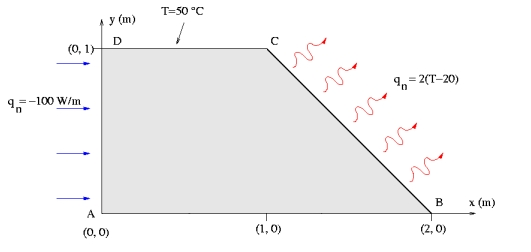

The temperature of the top side of the plate is 50º C and the bottom part is isolated. The heating source is applied at left part of the domain.  Convection constraint is applied at right part of the plate with  heat transfer coefficient of $h = 2 W/m^2ºC$, being $T_0 = 20ºC$ the ambient temperature of the fluid around the plate.

Governing Equation for Heat Transfer Derived from
Fourier’s law:

\begin{alignat}{2}
 - \nabla.(\kappa \nabla u) &=  f \quad &&\hbox{in }\Omega, \tag{1}
\end{alignat}

We define the heat flux boundary conditions:

\begin{alignat}{2}
-\kappa{\partial u\over\partial n} &= -100 W/mm \quad&&\mbox{on } (DA),\quad \tag{2}\\
-\kappa{\partial u\over\partial n} &= 2(T-20) \quad&&\mbox{on } (BC),\quad \tag{3}\\
-\kappa{\partial u\over\partial n} &= 0 \quad&&\mbox{on } (AB),\quad \tag{4}
\end{alignat}

Dirichlet boundary condition:
$$  
u = 50, \quad \mbox{on } (CD),\quad \tag{5}$$
The load:
$$f = 2xy, \quad \mbox{in }\Omega,\quad \tag{6}$$

In [ ]:
from dolfin import *
from mshr import *
import numpy
%matplotlib inline
import matplotlib.pyplot as plt

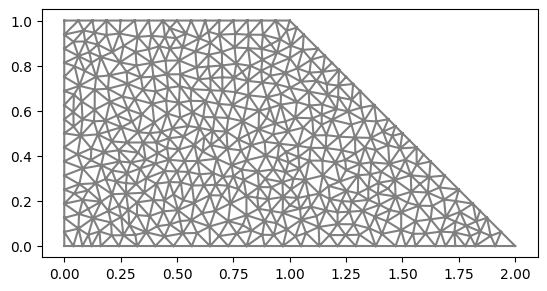

In [ ]:
# Create list of polygonal domain vertices
domain_vertices = [Point(0.0, 0.0),
                   Point(2.0, 0.0),
                   Point(1.0, 1.0),
                   Point(0.0, 1.0),
                   Point(0.0, 0.0)]
#
# Generate mesh and plot
domain = Polygon(domain_vertices)
#
mesh = generate_mesh(domain,20)
#
plot(mesh)
#
#  Define the function space.
#
Vh  = FunctionSpace(mesh, 'Lagrange', 1)
#
# Data
#
k = Constant(0.935)
u_f = Constant(50.)
h = Constant(2.)
T0 = Constant(20.)
g_a = Constant(0.)
g_b = Constant(100.)
f = Expression('2*x[0]*x[1]', degree=2)

In [ ]:
#  Define  the boundaries
#
# Define the Left part of the boundary  (x = 0 )
#
class left(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and abs(x[0]) < DOLFIN_EPS
#
# Define the Right part of the boundary ( x + y = 2)
#
class right(SubDomain):
  def inside(self, x, on_boundary):
    return near(x[1]+x[0]-2.0, 0.0)
#
# Define the Bottom part of the boundary  (y = 0 )
#
class bottom(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and abs(x[1]) < DOLFIN_EPS
#
# Define the Top part of the boundary ( y = 1)
#
def top ( x, on_boundary ):
  return on_boundary and abs(x[1] - 1) < DOLFIN_EPS
#
#   Mark the different parts of the boundary:
#
boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
#
# mark the entire boundary as 0
boundary_parts.set_all(0)
#
# Mark the boundaries as subdomains  1, 2 and 4
#
#    Bottom part of the boundary
#
Bottom_p = bottom()
Bottom_p.mark(boundary_parts, 1)
#
#    Left part of the boundary
#
Left_p = left()
Left_p.mark(boundary_parts, 4)
#
#    Right part of the boundary
#
Right_p = right()
Right_p.mark(boundary_parts, 2)

#
#   Dirichlet boundary condition:
#
bcs = [DirichletBC(Vh, u_f, top)]
#
# Define the integration on boundary
#
ds = Measure("ds", domain=mesh, subdomain_data=boundary_parts)

In [ ]:
u = TrialFunction(Vh)
v = TestFunction(Vh)
a =  k * inner(nabla_grad(u), nabla_grad(v))*dx +  h * u * v *ds(2)
b = f*v*dx + g_a*v*ds(1) + g_b*v*ds(4) + h * T0 * v *ds(2)

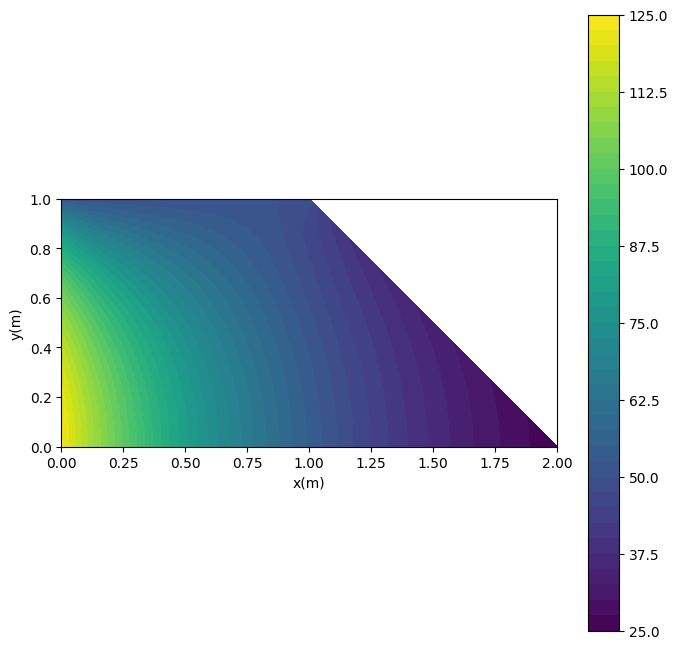

In [ ]:
u = Function ( Vh )

solve ( a == b, u, bcs )
#
# plot the solution at each step
#
plt.figure(figsize=(8,8))
p = plot(u)
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.colorbar(p)

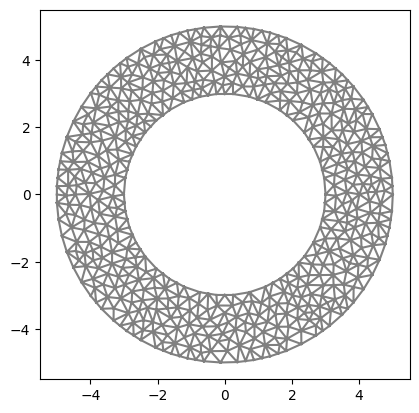

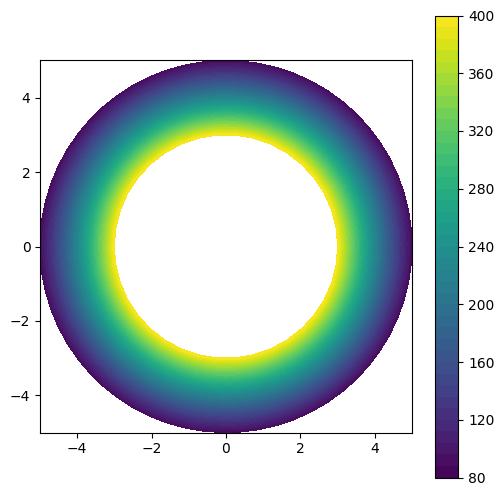

In [ ]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt

#
%matplotlib inline
r_ex = 5.0
r_in = 3.0

k = Constant(0.935) #conductivity
h = Constant(2.)
T0 = Constant(30.)

domain = Circle(Point(0,0),r_ex)- Circle(Point(0,0),r_in)

#
mesh = generate_mesh(domain, 20)
plot(mesh)

V = FunctionSpace(mesh, 'P', 1)

#  Use the expression to define the boundary condition.
def circle_intern(x, on_boundary):
  r = sqrt(x[0]*x[0]+x[1]*x[1])
  return on_boundary and r < r_in*1.1

u1 = Constant(400.)
bc1 = DirichletBC(V, u1, circle_intern)

class circle_extern(SubDomain):
  def inside(self, x, on_boundary):
    r1 = sqrt(x[0]*x[0]+x[1]*x[1])
    return on_boundary and r1 > r_ex*0.9

boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
boundary_parts.set_all(0)

Circle_extern = circle_extern()
Circle_extern.mark(boundary_parts, 1)


# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundary_parts)

# A list of boundary conditions for solve
bcs = [bc1]
#
#  Define the variational problem.
#
u = TrialFunction ( V )
v = TestFunction ( V )
#
f = Constant(0.0)
#
a = k*inner(nabla_grad(u), nabla_grad(v))*dx + h*u*v*ds(1)
L = f*v*dx + h*T0*v*ds(1)
#
#  Compute the solution.
#
uh = Function(V)
solve ( a == L, uh, bcs)


plt.figure(figsize=(6,6))
p = plot(uh)
plt.colorbar(p)
plt.show()